In [13]:
import os.path as op
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
subjects = [int(f[4:]) for f in os.listdir(bids_folder) if f[0:3] == 'sub' and len(f) == 6]

#target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')



In [14]:
from numrisk.utils.data import get_data_majduge

df = get_data_majduge()

number of subjects found: 66


In [15]:
from utils import get_decoding_info

pred = []
for sub in subjects:
    pred.append(get_decoding_info(sub,bids_folder=bids_folder))

pred = pd.concat(pred).join(df, how='inner')

/Users/mrenke/data/ds-dnumrisk/derivatives/decoded_pdfs.volume.cv_vselect.denoise/sub-03/func/sub-03_ses-1_mask-NPC_R_space-T1w_pars.tsv


In [16]:
import pingouin as pg

r = pred.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d['log(n1)']))

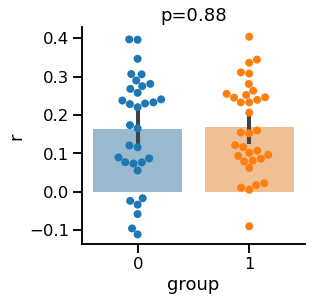

In [17]:
temp = r.groupby(['subject','group']).mean()
sns.set_context('talk')

y_var = 'r'
an = pg.anova(data=temp.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(ax=ax,data=temp.reset_index(), x='group', y=y_var, alpha=0.5)
sns.swarmplot(ax=ax, data=temp.reset_index(), x='group', y=y_var,  hue='group',size=8,legend=False)
ax.set(title=f'p={p_val}') # ylim=(0.5,1),
sns.despine()

In [18]:
target_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

r.reset_index(['group', None])[['r']].to_csv(op.join(target_folder,'decoding_r.csv'))

In [19]:
source_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

magjudge_probit_params = pd.read_csv(op.join(source_folder,'probit-2_all-subwise-params.csv')).set_index('subject')

gammas_symbolic = pd.read_csv(op.join(source_folder, f'probit_model-2_format-symbolic_gammas.csv'))
gammas_symbolic = gammas_symbolic.set_index('subject').drop(columns=['Unnamed: 0'])

df_comb = r.reset_index(['group', None])[['r', 'group']].join(magjudge_probit_params, how='inner').join(gammas_symbolic, how='inner',rsuffix='_symbolic')
df_comb.head()

,r,group,gamma,intercept,n1|subject,gamma_symbolic
subject,,,,,,
1,-0.058083,0,4.583617,-0.177108,-0.009172,4.144728
2,0.206071,1,3.547053,0.021933,0.000715,0.804526
4,-0.089840,1,5.052103,-0.160951,-0.009397,1.937536
5,-0.023735,0,3.478226,-0.255322,-0.012253,2.407660
6,0.062036,1,4.457349,-0.063814,-0.006156,2.204173


In [27]:
model_label =1 # 1 n1_evidence_sd & n2_evidence_sd, 3 = memory_noise_sd & perceptual_noise_sd
magjudge_bauer_params = pd.read_csv(op.join(source_folder,f'magjudge_bauer-{model_label}_sds.csv')).set_index('subject')

df_comb = r.reset_index(['group', None])[['r']].join(magjudge_bauer_params, how='inner')
df_comb.head()

,r,n1_evidence_sd,n2_evidence_sd,group
subject,,,,
1,-0.058083,0.199131,0.082536,0
2,0.206071,0.294919,0.035016,1
4,-0.089840,0.200174,0.030707,1
5,-0.023735,0.223037,0.159042,0
6,0.062036,0.227031,0.035987,1


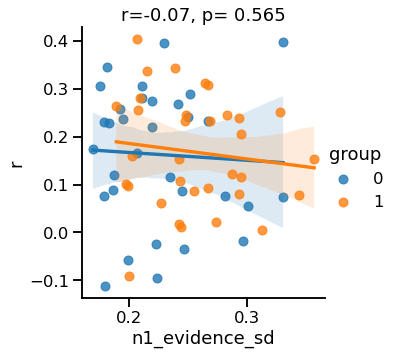

In [29]:
import pingouin

#df_comb = df_comb[df_comb['group'] == 1]
y_var = 'r' 
x_var = 'n1_evidence_sd'#'gamma'

cor = pingouin.corr(df_comb[y_var], df_comb[x_var])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 3)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb, hue='group') # 
fig.set(title=f'r={r_}, p= {p}') 

In [8]:
magjudge_probit_params

,gamma,intercept,n1|subject
subject,,,
1,4.583617,-0.177108,-0.009172
2,3.547053,0.021933,0.000715
3,2.811804,-0.129337,-0.002053
4,5.052103,-0.160951,-0.009397
5,3.478226,-0.255322,-0.012253
...,...,...,...
62,5.416376,-0.128222,-0.001831
63,3.317845,-0.118790,-0.012347
64,4.032603,-0.011574,-0.002938


In [9]:
r

,,,n,r,CI95%,p-val,BF10,power
subject,group,,,,,,,
1,0,pearson,180,-0.058083,"[-0.2, 0.09]",0.438643,0.126,0.121123
2,1,pearson,173,0.206071,"[0.06, 0.34]",0.006527,3.727,0.780216
4,1,pearson,178,-0.089840,"[-0.23, 0.06]",0.233035,0.19,0.222729
5,0,pearson,179,-0.023735,"[-0.17, 0.12]",0.752483,0.098,0.061401
6,1,pearson,180,0.062036,"[-0.08, 0.21]",0.408064,0.131,0.131454
...,...,...,...,...,...,...,...,...
60,0,pearson,180,0.229764,"[0.09, 0.36]",0.001917,11.045,0.877014
61,0,pearson,179,-0.095490,"[-0.24, 0.05]",0.203541,0.209,0.246814
62,0,pearson,179,0.305624,"[0.17, 0.43]",0.000032,499.349,0.987423
